In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(13, 7.5)})
sns.set_context('talk')

# Generate random data

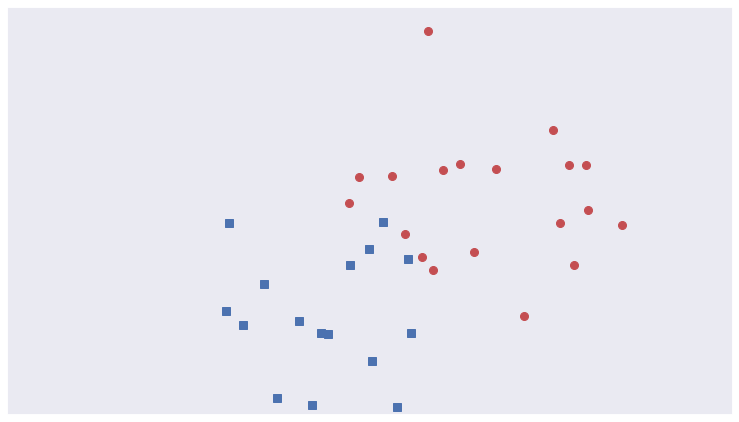

In [5]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 1], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)

with PdfPages('data.pdf') as pdf:
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
    plt.axis('equal')
    plt.ylim(0, 4)
    plt.xlim(0, 5)

    #plt.xlabel('$x_1$', fontsize = 20)
    #plt.ylabel('$x_2$', fontsize = 20)

    # hide tikcs 
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    
    #pdf.savefig()
    #plt.savefig('logistic_2d.png', bbox_inches='tight', dpi = 300)
    plt.show()

In [55]:
X = np.vstack((X0, X1))
y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape((2*N,))

In [9]:
#3Solving by sklearn
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]

NameError: name 'y' is not defined

In [ ]:
print(w_sklearn, '\n', b_sklearn)

[[-4.81413725]
 [-5.96033961]] 
 22.70752936411212


In [ ]:
! pip install cvxopt

In [10]:
#By dual problems
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

NameError: name 'y' is not defined

In [58]:
S = np.where(l > 1e-5)[0]
S2 = np.where(l < .99*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

In [59]:
XT = X.T # we need each col is one data point in this alg
VS = V[:, S]
# XS = XT[:, S]
# yS = y[ S]
lS = l[S]
# lM = l[M]
yM = y[M]
XM = XT[:, M]
w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))

In [60]:
#Solving by Hinge loss
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
            .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1]
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

X0_ext = X0_bar
w0 = np.random.randn(X0_ext.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient difference: %f' %diff)

Gradient difference: 0.000000


In [61]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 
w0 = np.random.randn(X0_ext.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]


iter 1 cost: 70.826831
iter 10001 cost: 5.669748
iter 20001 cost: 4.944371
iter 30001 cost: 4.819895
iter 40001 cost: 4.746380
iter 50001 cost: 4.670747
iter 60001 cost: 4.598705
iter 70001 cost: 4.528775
iter 80001 cost: 4.456803
iter 90001 cost: 4.387742


In [ ]:
X0

array([[ 1.92306918,  0.775673  ],
       [ 2.90509186,  1.7997662 ],
       [ 1.58909188,  1.16143907],
       [ 2.76874122,  1.07663514],
       [ 2.52416203,  1.53020387],
       [ 2.02414192,  1.80692632],
       [ 2.49174878,  2.62943405],
       [ 1.11439322,  2.88348991],
       [ 2.62561276,  2.89077234],
       [ 3.27183166,  0.75454543],
       [ 3.55617919,  0.66250438],
       [ 1.45945603,  2.28222634],
       [ 2.87575608,  2.52637908],
       [ 2.30375703,  2.46497356],
       [ 1.08925412,  2.01982447],
       [ 4.09096119, -0.08330889],
       [ 1.80350003,  1.91837255],
       [ 1.25827634,  1.8856175 ],
       [ 2.08532169,  1.79005729],
       [ 1.9340609 ,  1.09208652]])

In [ ]:
np.shape(X0)

(20, 2)

In [ ]:
X0[:, 0]

array([1.92306918, 2.90509186, 1.58909188, 2.76874122, 2.52416203,
       2.02414192, 2.49174878, 1.11439322, 2.62561276, 3.27183166,
       3.55617919, 1.45945603, 2.87575608, 2.30375703, 1.08925412,
       4.09096119, 1.80350003, 1.25827634, 2.08532169, 1.9340609 ])

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [82]:
! pip install latex

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 829.2/829.2 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for latex, since package 'wheel' is not installed.
Using legacy 'setup.py install' for data, since package 'wheel' is not installed.
Using legacy 'setup.py install' for future, since package 'wheel' is not installed.
Using legacy 'setup.py install' for shutilwhich, since package 'wheel' is not installed.
Using legacy 'setup.py install' for tempdir, since package 'wheel' is no

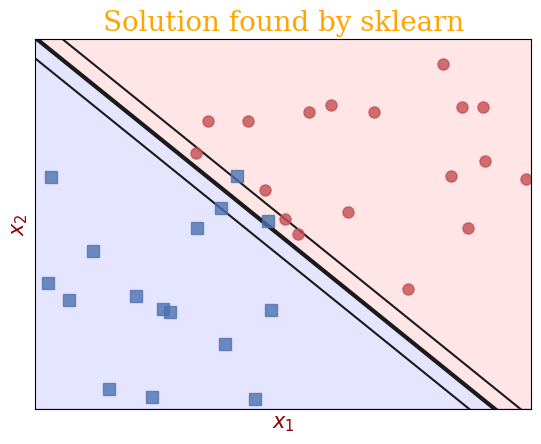

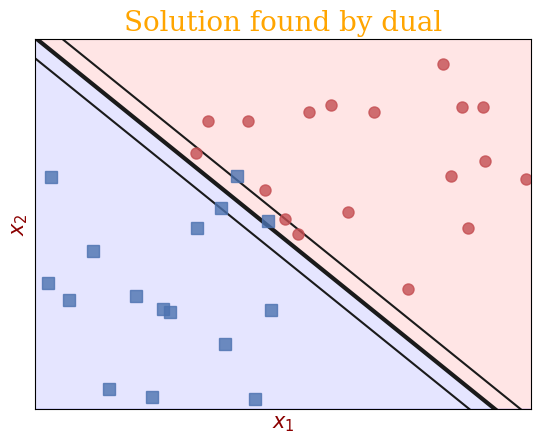

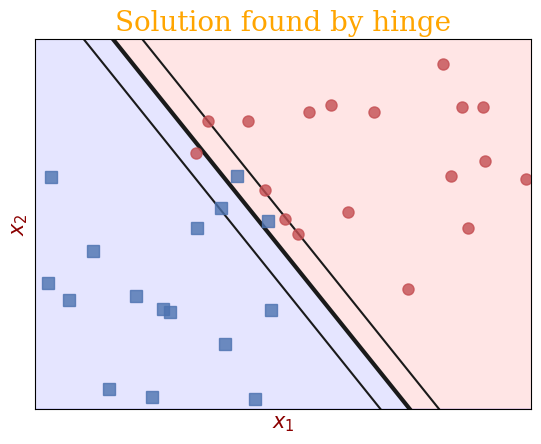

In [90]:
def myplot(X0, X1, w, b, filename, tit):
    with PdfPages(filename) as pdf:
        fig, ax = plt.subplots()

        w0 = float(w[0])
        w1 = float(w[1])
        x1 = np.arange(-10, 10, 0.1)
        y1 = -w0/w1*x1 - b/w1
        y2 = -w0/w1*x1 - (b-1)/w1
        y3 = -w0/w1*x1 - (b+1)/w1

        type1 = {'family':'serif','color':'orange','size':20}
        type2 = {'family':'serif','color':'darkred','size':15}

        
        plt.xlabel('$x_1$', fontdict = type2)
        plt.ylabel('$x_2$', fontdict = type2)
        plt.title('Solution found by ' + tit, fontdict = type1)
        # draw linear
        plt.plot(x1, y1, 'k', linewidth = 3)
        plt.plot(x1, y2, 'k')
        plt.plot(x1, y3, 'k')
        
        # fill two regions
        y4 = 10*x1
        plt.fill_between(x1, y1, color = 'blue', alpha= 0.1)
        plt.fill_between(x1, y1, y4, color = 'red', alpha = 0.1)

        # equal axis and lim
        plt.axis('equal')
        plt.ylim(0, 3)
        plt.xlim(2, 4)

        # hide tikcs 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])
  
        plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8)
        plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8)
        #pdf.savefig()
        
        plt.show()

def f(x):
    return np.int(x)
f2 = np.vectorize(f)
import numpy as np
myplot(X0, X1, w_sklearn, b_sklearn, 'svm_sklearn.pdf', 'sklearn')
myplot(X0, X1, w_dual, b_dual, 'svm_dual.pdf', 'dual')
myplot(X0, X1, w_hinge, b_hinge, 'svm_hinge.pdf', 'hinge')
  

[0. 1. 1. 0.] [0 1] [0 1]
[[-2.         -2.         -2.         ... -2.         -2.
  -2.        ]
 [-1.97487437 -1.97487437 -1.97487437 ... -1.97487437 -1.97487437
  -1.97487437]
 [-1.94974874 -1.94974874 -1.94974874 ... -1.94974874 -1.94974874
  -1.94974874]
 ...
 [ 2.94974874  2.94974874  2.94974874 ...  2.94974874  2.94974874
   2.94974874]
 [ 2.97487437  2.97487437  2.97487437 ...  2.97487437  2.97487437
   2.97487437]
 [ 3.          3.          3.         ...  3.          3.
   3.        ]]
[0. 1. 1. 0.] [0 1] [0 1]
[[-2.         -2.         -2.         ... -2.         -2.
  -2.        ]
 [-1.97487437 -1.97487437 -1.97487437 ... -1.97487437 -1.97487437
  -1.97487437]
 [-1.94974874 -1.94974874 -1.94974874 ... -1.94974874 -1.94974874
  -1.94974874]
 ...
 [ 2.94974874  2.94974874  2.94974874 ...  2.94974874  2.94974874
   2.94974874]
 [ 2.97487437  2.97487437  2.97487437 ...  2.97487437  2.97487437
   2.97487437]
 [ 3.          3.          3.         ...  3.          3.
   3.       

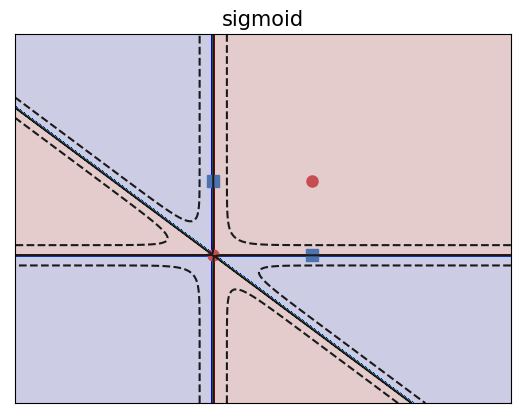

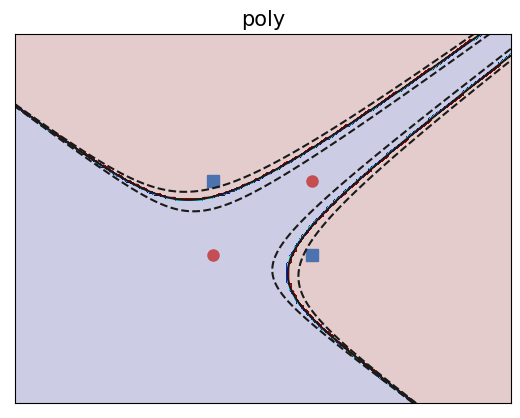

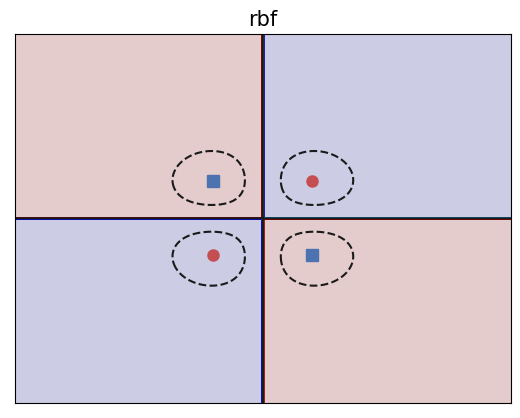

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import svm

# XOR dataset and targets
X = np.c_[(0, 0),
          (1, 1),
          #---
          (1, 0),
          (0, 1)].T
Y = [0] * 2 + [1] * 2
# figure number
fignum = 1

# fit the model
for kernel in ('sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=4, coef0 = 0)
    clf.fit(X, Y)
    with PdfPages(kernel + '2.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(4, 3))
        plt.clf()
        print(clf.support_vectors_[:, 0],X[:2, 0], X[:2, 1])
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                    facecolors='None') 
        plt.plot(X[:2, 0], X[:2, 1], 'ro', markersize = 8)
        plt.plot(X[2:, 0], X[2:, 1], 'bs', markersize = 8)

        plt.axis('tight')
        x_min, x_max = -2, 3
        y_min, y_max = -2, 3
        
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        #pdf.savefig()
plt.show()

In [27]:
import scipy.io as sio
from sklearn.svm import SVC

A = sio.loadmat('myARgender.mat')
X_train = A['Y_train'].T    
X_test = A['Y_test'].T 
N = 700
y_train = A['label_train'].reshape(N)
y_test = A['label_test'].reshape(N)

clf = SVC(kernel='poly', degree = 3, gamma=1, C = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: %.2f %%" %(100*accuracy_score(y_test, y_pred)))


NameError: name 'accuracy_score' is not defined